In [101]:
from anndata import AnnData
import numpy as np
import scanpy as sc
from scipy import sparse
from scipy.stats import rankdata

Load a test dataset

In [2]:
adata = sc.datasets.pbmc3k()

In [3]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

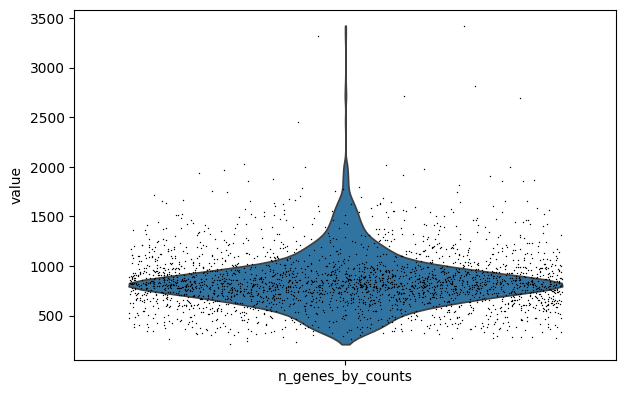

In [117]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
sc.pl.violin(adata, 'n_genes_by_counts', jitter=0.4)

In [81]:
# Param
layer = None
max_rank = 300
chunk_cells = 200
ties_method = "average"

In [82]:
X = adata.layers[layer] if layer else adata.X
n_cells, n_genes = X.shape

# Convert to csc for fast column slicing
is_sparse = sparse.issparse(X)
Xarr = X.toarray() if is_sparse else np.asarray(X)

In [83]:
adata.layers

Layers with keys: 

In [84]:
data, rows, cols = [], [], []

In [85]:
for j in range(n_cells):
    col = Xarr[j, :].astype(float)
    # rank high expression as rank 1
    col[np.isnan(col)] = -np.inf
    ranks = rankdata(-col, method=ties_method)

    # store only ranks <= max_rank
    mask = ranks <= max_rank
    good_idx = np.nonzero(mask)[0]
    good_ranks = ranks[good_idx].astype(np.int32)

    data.extend(good_ranks)
    rows.extend(good_idx)
    cols.extend([j] * len(good_idx))


        

In [86]:
ranks_mat = sparse.coo_matrix(
    (np.array(data, dtype=np.int32),
     (np.array(rows, dtype=np.int32),
      np.array(cols, dtype=np.int32))),
    shape=(n_genes, n_cells)
).tocsr()
ranks_mat

<Compressed Sparse Row sparse matrix of dtype 'int32'
	with 670808 stored elements and shape (32738, 2700)>

In [87]:
print(ranks_mat[1:100, 1:5])

<Compressed Sparse Row sparse matrix of dtype 'int32'
	with 2 stored elements and shape (99, 4)>
  Coords	Values
  (41, 2)	54
  (80, 2)	174


In [88]:
n_cells, n_genes = X.shape
nnz_per_cell = max_rank  # at most max_rank entries per cell
nnz_total = n_cells * nnz_per_cell

data = np.empty(nnz_total, dtype=np.int32)
rows = np.empty(nnz_total, dtype=np.int32)
cols = np.empty(nnz_total, dtype=np.int32)

ptr = 0
for j in range(n_cells):
    col = Xarr[j, :].astype(float)
    col[np.isnan(col)] = -np.inf
    ranks = rankdata(-col, method=ties_method)
    mask = ranks <= max_rank
    idx = np.nonzero(mask)[0]
    rks = ranks[idx].astype(np.int32)
    n = len(idx)

    data[ptr:ptr+n] = rks
    rows[ptr:ptr+n] = idx
    cols[ptr:ptr+n] = j
    ptr += n

# slice arrays to actual size
data = data[:ptr]; rows = rows[:ptr]; cols = cols[:ptr]

ranks_mat = sparse.coo_matrix((data, (rows, cols)), shape=(n_genes, n_cells)).tocsr()

In [89]:
print(ranks_mat[1:100, 1:5])

<Compressed Sparse Row sparse matrix of dtype 'int32'
	with 2 stored elements and shape (99, 4)>
  Coords	Values
  (41, 2)	54
  (80, 2)	174


In [90]:
a = ranks_mat[:, 1]
a[a==0] = max_rank
a_dense = a.toarray().ravel()

top_indices = np.argsort(a_dense)[:10]  # minus sign for descending order
top_values = a_dense[top_indices]

print("Top indices:", top_indices)
print("Top values:", top_values)

Top indices: [19154 24673 14247 30970 15745 23794 13302   908 11447 10709]
Top values: [1 2 3 4 4 6 7 7 9 9]


Define ranking function

In [136]:
def get_rankings(
    data,
    layer: str = None,
    max_rank: int = 1500,
    ties_method: str = "average",
) -> sparse.csr_matrix:
    """
    Compute per-cell ranks of genes for an AnnData object.

    Parameters
    ----------
    data : AnnData | np.ndarray | sparse matrix
        Either an AnnData object (cells x genes) or directly a 2D matrix.
    layer : str, optional
        Only used if input is AnnData. Which layer to use (None = adata.X).
    max_rank : int, optional
        Cap ranks at this value (ranks > max_rank are dropped for sparsity).
    ties_method : str, optional
        Passed to scipy.stats.rankdata.

    Returns
    -------
    ranks : csr_matrix of shape (genes, cells)
        Sparse matrix of ranks.
    """

    # Accept either AnnData or matrix directly
    if isinstance(data, AnnData):
        X = data.layers[layer] if layer else data.X
    else:
        X = data

    n_cells, n_genes = X.shape

    # Convert to array
    is_sparse = sparse.issparse(X)
    Xarr = X.toarray() if is_sparse else np.asarray(X)

    # Allocate vectors, at most max_rank entries per cell
    n_cells, n_genes = X.shape
    nnz_per_cell = max_rank 
    nnz_total = n_cells * nnz_per_cell

    data = np.empty(nnz_total, dtype=np.int32)
    rows = np.empty(nnz_total, dtype=np.int32)
    cols = np.empty(nnz_total, dtype=np.int32)

    #Calculate ranks, while keeping the matrix sparse
    ptr = 0
    for j in range(n_cells):
        col = Xarr[j, :].astype(float)
        col[np.isnan(col)] = -np.inf
        ranks = rankdata(-col, method=ties_method)
        mask = ranks <= max_rank  #mask out ranks to impose sparsity
        idx = np.nonzero(mask)[0]
        rks = ranks[idx].astype(np.int32)
        n = len(idx)

        data[ptr:ptr+n] = rks
        rows[ptr:ptr+n] = idx
        cols[ptr:ptr+n] = j
        ptr += n

    # slice arrays to actual size
    data = data[:ptr]
    rows = rows[:ptr]
    cols = cols[:ptr]

    ranks_mat = sparse.coo_matrix((data, (rows,cols)), shape=(n_genes,n_cells)).tocsr()
    
    return ranks_mat

In [112]:
ranks1 = get_rankings(adata)
print(ranks1[1:200, 1:5])

<Compressed Sparse Row sparse matrix of dtype 'int32'
	with 22 stored elements and shape (199, 4)>
  Coords	Values
  (41, 1)	743
  (41, 2)	54
  (50, 0)	315
  (52, 1)	743
  (66, 0)	876
  (66, 2)	640
  (69, 1)	743
  (80, 0)	876
  (80, 2)	174
  (84, 0)	315
  (92, 2)	640
  (112, 0)	876
  (112, 1)	743
  (112, 2)	640
  (117, 1)	743
  (119, 0)	876
  (120, 2)	640
  (146, 1)	743
  (165, 0)	206
  (165, 1)	743
  (165, 2)	257
  (188, 0)	876


In [113]:
ranks2 = get_rankings(adata, max_rank=100)
print(ranks2[1:200, 1:5])

<Compressed Sparse Row sparse matrix of dtype 'int32'
	with 1 stored elements and shape (199, 4)>
  Coords	Values
  (41, 2)	54


In [115]:
ranks3 = get_rankings(adata, max_rank=3000)
print(ranks3[1:200, 1:5])

<Compressed Sparse Row sparse matrix of dtype 'int32'
	with 22 stored elements and shape (199, 4)>
  Coords	Values
  (41, 1)	743
  (41, 2)	54
  (50, 0)	315
  (52, 1)	743
  (66, 0)	876
  (66, 2)	640
  (69, 1)	743
  (80, 0)	876
  (80, 2)	174
  (84, 0)	315
  (92, 2)	640
  (112, 0)	876
  (112, 1)	743
  (112, 2)	640
  (117, 1)	743
  (119, 0)	876
  (120, 2)	640
  (146, 1)	743
  (165, 0)	206
  (165, 1)	743
  (165, 2)	257
  (188, 0)	876


In [124]:
signatures = {
    "T_cell": ["CD3D", "CD3E", "CD2"],     # T cell marker genes
    "B_cell": ["MS4A1", "CD79A", "CD79B"]  # B cell marker genes
}

In [205]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/Users/mass/.pyenv/versions/3.11.11/envs/scverse/lib/python3.11/site-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 32738 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(
/Users/mass/.pyenv/versions/3.11.11/envs/scverse/lib/python3.11/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


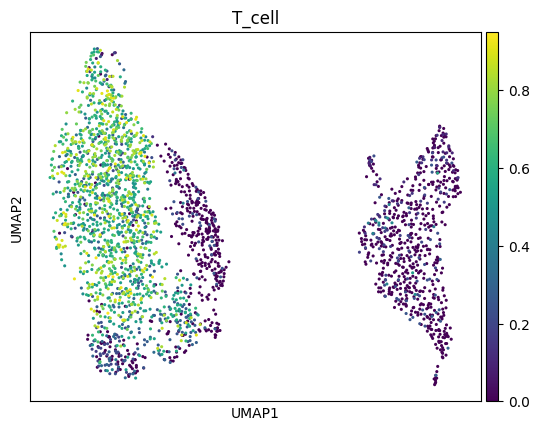

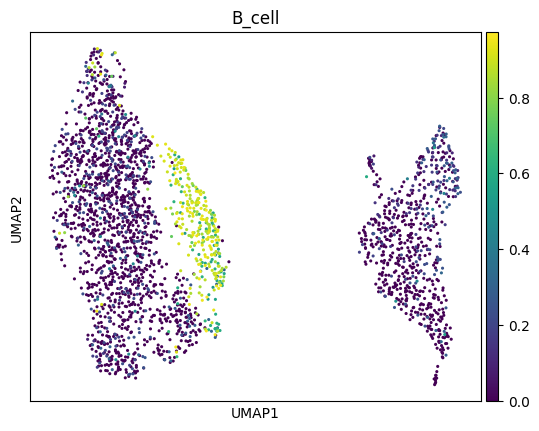

In [206]:
sc.pl.umap(adata, color='T_cell', cmap='viridis', size=20)
sc.pl.umap(adata, color='B_cell', cmap='viridis', size=20)